# Fitting a line to data using MCMC

In this example we will be going over Exercise 6 from [Hogg 2010](http://arxiv.org/abs/1008.4686).  We will be fitting a line to data using a model that rejects outliers using an MCMC sampler.

## Packages being used
+ `numpy`: doing math on arrays
+ `scipy`: more useful functions here
+ `emcee`: this does the heavy lifting for the MCMC code
+ `matplotlib`: plot our results
+ `astropy`: useful hist function

## Relevant documentation
+ `scipy`: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logsumexp.html
+ `emcee`: https://emcee.readthedocs.io/en/stable/
+ `matplotlib`: https://matplotlib.org/stable/api/pyplot_summary.html
+ `astropy`: http://docs.astropy.org/en/stable/visualization/histogram.html

In [116]:
import numpy as np
from scipy.special import logsumexp
from matplotlib import pyplot as plt
import emcee
from astropy.visualization import hist
from astropy.table import Table
from extract import extract_data,extract_direct
# import mpl_style
# %matplotlib inline
# plt.style.use(mpl_style.style1)

### Read in the data
First lets read in the data we will be fitting (`.data` returns the raw data array):

In [117]:

logMbar_sers,logMbar_err_sers, logMstar_sers,logMstar_err_sers,logVRout,logVRout_err=extract_data()
Mbar,Mbar_err,Mstar,Mstar_err,Mgas,Mgas_err,VRout,VRout_err = extract_direct()

x = logVRout
y = logMbar_sers
sy = logMbar_err_sers
sx = logVRout_err

### Plot the data
Lets take a look at our data to see what we are fitting:

Text(0, 0.5, 'y')

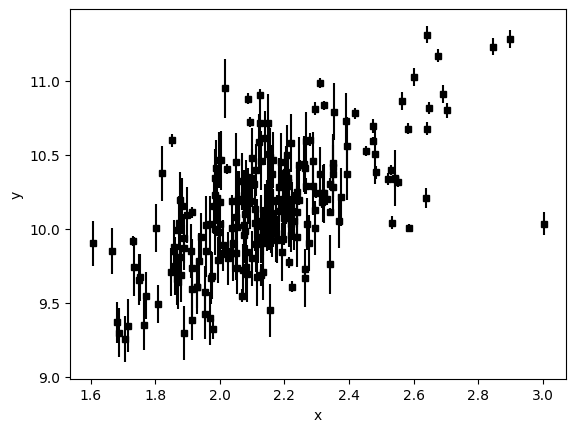

In [118]:
plt.figure(1)
plt.errorbar(
    x,
    y,
    sy,
    # sx,
    ls='None',
    mfc='k',
    mec='k',
    ms=5,
    marker='s',
    ecolor='k'
)
plt.xlabel('x')
plt.ylabel('y')
# plt.ylim(0, 700)

### Define the model
To use `emcee` we need to define the log(likelihood) function we are trying to maximize.  The likelihood we need for this fit is shown in equation 17 of [Hogg 2010](http://arxiv.org/abs/1008.4686):

$$\mathscr{L} \propto \prod_{i=1}^{N}{\left[\frac{1-P_{b}}{\sqrt{2 \pi \sigma_{yi}^{2}}} \exp{\left(-\frac{[y_{i} - m x_{i} - b]^2}{2 \sigma_{yi}^{2}}\right)} + \frac{P_{b}}{\sqrt{2 \pi [V_{b}+\sigma_{yi}^{2}]}} \exp{\left( -\frac{[y_{i} - Y_{b}]^2}{2[V_{b}+\sigma_{yi}^{2}]} \right)} \right]}$$

where $x_{i}, y_{i}, \sigma_{yi}$ are the data from the `.csv` file, $m, b$ are the slope and intercept of the line we are fitting, $P_b$ is the probability of a point being an outlier, and $Y_{b}, V_{b}$ are the parameters of the distribution those outliers are draw from.  See section 3 of Hogg's paper for a full derivation.

Since we will be using a Bayesian approach to this fitting, we need to define priors for our fit parameters $\theta = \left[ m, b, P_b, Y_b, V_b \right]$.  We will use flat priors in all the parameters except $V_b$ which will be flat on the log.

In [119]:
def lnprior(theta):
    m, b, Pb, Yb, Vb = theta
    if (0 < m < 10) and (0 < b < 10) and (0 < Pb < 1) and (-10 < Yb < 20) and (0 < np.log(Vb) < 2):
        return 0.0
    else:
        return -np.inf

To make life easy, we will first write a general function of the log(likelihood) of a general Gaussian distribution for the residuals of the data points from a model:

In [120]:
def lnGau(model, y, var):
    residual = (y - model)**2
    return -0.5 * (np.log(2 * np.pi * var) + residual / var)

This makes it easier to write the above equation as a function.  In `emcee` all the data parameters being fit will come in as the first variable in the log(likelihood) function.  To avoid numerical overflow we will use `scipy`'s `logsumexp` function to define this model:

In [121]:
def lnprob(theta, x, y, sy):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        # if the params are outside the prior range return -inf
        return -np.inf
    m, b, Pb, Yb, Vb = theta
    # probability of the data points in the line model
    lnpf = lnGau((m * x + b)/np.sqrt(m**2+1), y/np.sqrt(m**2+1), sy**2)
    # probability of the data points in the outlier model
    lnpb = lnGau(Yb, y, Vb + sy**2)
    # combine both probabilities with the propper coefficients and sum them up
    lnlike = logsumexp([lnpf, lnpb], b=[[1 - .3*Pb], [.3*Pb]], axis=0).sum()
    return lp + lnlike

### Set up the MCMC sampler
`emcee` uses an ensemble sampling technique where it sends out $N$ walkers to explore the likelihood space and create a sampling from it.  These walkers all need to start in a reasonable part of parameters space:

In [122]:
# number of parameters being fit
ndim = 5
# number of walkers to use (should be > 2*ndim)
nwalkers = 300
# good starting point
p0 = np.array([1, 10, 0.5, 10, 2])
# start each walker in a small ball around this position
pos = [p0 + 1e-4 * np.random.randn(5) for i in range(nwalkers)]

**Note** For the walkers to move around the parameter space the starting positions must all have _finite_ prior probabilities (i.e. `lnprior(pos)` is finite for all values).

### Run the sampler
Next we have to set up our sampler and run it.  For this fit we will let it run for 1000 steps.

In [123]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, sy))
sampler.run_mcmc(pos, 3000,progress=True);

  0%|          | 0/3000 [00:00<?, ?it/s]c:\Users\varen\AppData\Local\Programs\Python\Python310\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 90/3000 [00:06<03:23, 14.29it/s]C:\Users\varen\AppData\Local\Temp\ipykernel_1676\1507542123.py:3: RuntimeWarning: invalid value encountered in log
  if (0 < m < 10) and (0 < b < 10) and (0 < Pb < 1) and (-10 < Yb < 20) and (0 < np.log(Vb) < 2):
100%|██████████| 3000/3000 [04:43<00:00, 10.59it/s]


### Check for convergence
When that is done running we should check that our walkers have converged on a solution:

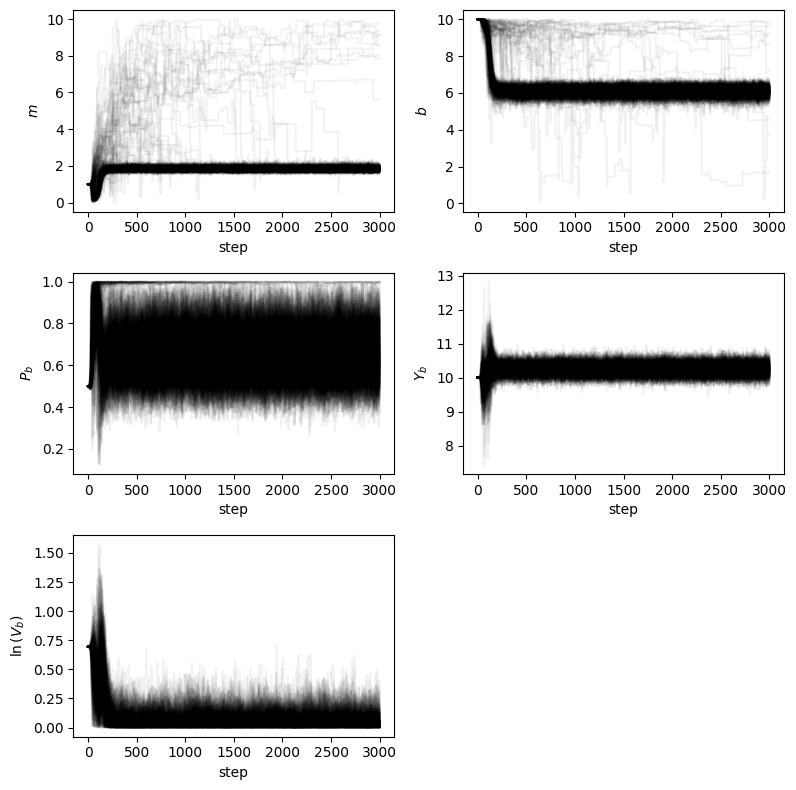

In [124]:
plt.figure(2, figsize=(8, 8))
plt.subplot2grid((3, 2), (0, 0))
plt.plot(sampler.chain[:, :, 0].T, alpha=0.05, color='k')
plt.ylabel(r'$m$')
plt.xlabel('step')
plt.subplot2grid((3, 2), (0, 1))
plt.plot(sampler.chain[:, :, 1].T, alpha=0.05, color='k')
plt.ylabel(r'$b$')
plt.xlabel('step')
plt.subplot2grid((3, 2), (1, 0))
plt.plot(sampler.chain[:, :, 2].T, alpha=0.05, color='k')
plt.ylabel(r'$P_b$')
plt.xlabel('step')
plt.subplot2grid((3, 2), (1, 1))
plt.plot(sampler.chain[:, :, 3].T, alpha=0.05, color='k')
plt.ylabel(r'$Y_b$')
plt.xlabel('step')
plt.subplot2grid((3, 2), (2, 0))
plt.plot(np.log(sampler.chain[:, :, 4].T), alpha=0.05, color='k')
plt.ylabel(r'$\ln{(V_b)}$')
plt.xlabel('step')
plt.tight_layout()
plt.savefig('outlier_convergence.png')

### Remove the burn-in and find the 1-$\sigma$ cofidence interval
From these plots we can see it took ~400 steps for the MCMC chain to converge, so we will create our final sample from the last half of the chain.  Taking the median of these value will give us our best fit params, and taking the middle 68% will give us our upper and lower confidence intervals:

In [125]:
# sampler.chain has shape [nwalkers, nsteps, ndim]
samples = sampler.chain[:, 400:, :].reshape((-1, ndim))
fits = np.percentile(samples, [16, 50, 84], axis=0)
fits_pm = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*fits))
print(list(fits_pm))

[(1.8502779273505046, 0.12026394693971354, 0.10216442387836899), (6.102692912047942, 0.24649857830644795, 0.2397261993013462), (0.6578623850252076, 0.12663220855545088, 0.10587499653605625), (10.24803960867903, 0.16177471092657925, 0.14935047622533482), (1.0369381341255464, 0.06683449328577273, 0.028627419957546918)]


### Plot the marginalized posterior probabilities
With a sampling from our posterior probability distribution we can visualize the full covariance between $m$ and $b$:

Text(0, 0.5, '$b$')

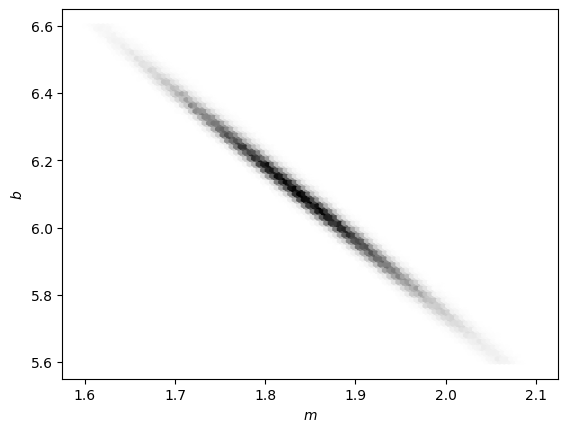

In [126]:
plt.figure(3)
plt.hexbin(samples[:, 0], samples[:, 1], gridsize=100, mincnt=1,cmap='Greys', extent=[1.6, 2.1, 5.6, 6.6])
plt.xlabel(r'$m$')
plt.ylabel(r'$b$')

And the fully marginalized distributions:

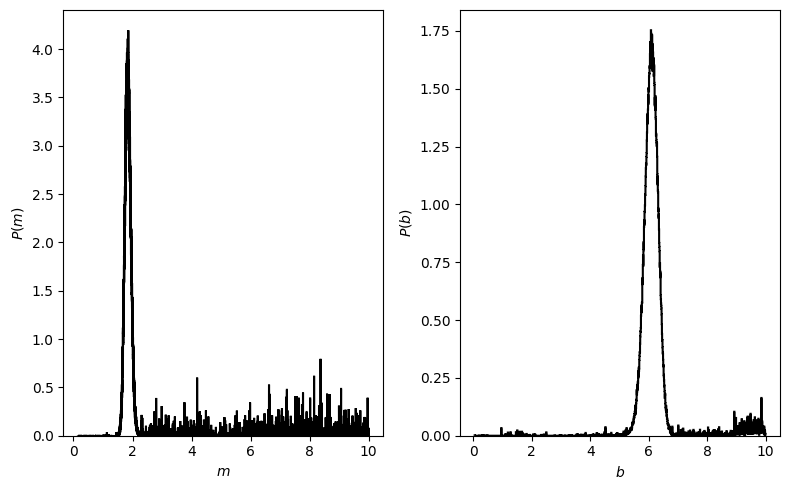

In [127]:
plt.figure(4, figsize=(8, 5))
plt.subplot2grid((1, 2), (0, 0))
values, bins, patches = hist(
    samples[:, 0],
    bins='knuth',
    histtype='step',
    color='k',
    density=True,
    lw=1.5
)
plt.xlabel(r'$m$')
plt.ylabel(r'$P(m)$')
plt.subplot2grid((1, 2), (0, 1))
values, bins, patches = hist(
    samples[:, 1],
    bins='knuth',
    histtype='step',
    color='k',
    density=True,
    lw=1.5
)
plt.xlabel(r'$b$')
plt.ylabel(r'$P(b)$')
plt.tight_layout()

As a bonus we can also see what fraction of our data points are outliers:

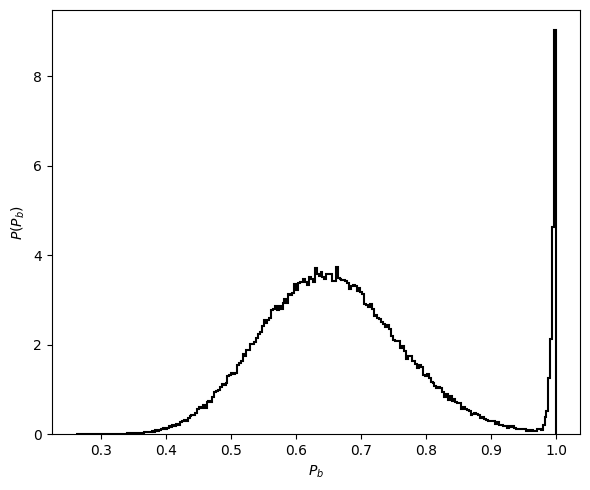

In [128]:
plt.figure(5, figsize=(6, 5))
# use astropy's hist function so it can pick optimal bin sizes
values, bins, patches = hist(
    samples[:, 2],
    bins='knuth',
    histtype='step',
    color='k',
    density=True,
    lw=1.5
)
plt.xlabel(r'$P_b$')
plt.ylabel(r'$P(P_b)$')
plt.tight_layout()

This indicates there are ~4 outliers in our sample.

### Plot the final fit
Now that we have best fit line (along with a representative sample) lets place it our data to see how well it did:

6.102692912047942 1.8502779273505046


(1.0, 3.5)

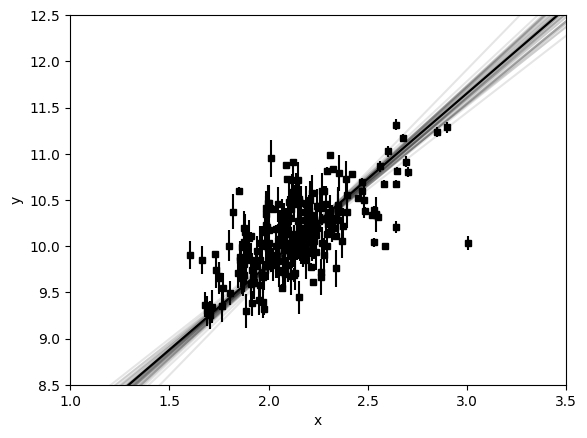

In [129]:
X = np.linspace(0, 3.5, 500)
# pick 40 random parameter sets from the final sample
idx = np.random.randint(samples.shape[0], size=40)
# plot the data
plt.figure(6)
plt.errorbar(
    x,
    y,
    sy,
    ls='None',
    mfc='k',
    mec='k',
    ms=5,
    marker='s',
    ecolor='k'
)
# plot the best fit line
plt.plot(X, fits[1][0] * X + fits[1][1], color='k')
print(fits[1][1],fits[1][0])
# plot a sample of best fit lines
for i in idx:
    f = samples[i]
    plt.plot(X, f[0] * X + f[1], color='k', alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(8.5,12.5)
plt.xlim(1,3.5)

As you can see this does a good job of finding the best fit line while rejecting outliers.

Working through a bit of math, we can also determine what points are the outliers.  The function below takes in a sample from the posterior probability distribution and calculates the likelihoods for each data point coming from the foreground and background distributions (with the priors).  If it has a higher likelihood of coming from the background it will return `True`, otherwise `False`.  Evaluating this function at each sample position, and taking the median over all samples gives us a mask we can use to select the outliers and plot them as a different color.

1.8502779273505046 6.102692912047942
237 115
[ True False False False  True  True False False False False False False
 False False  True False  True False False False False  True False False
 False False  True False  True  True  True False False False False False
 False False  True False False False  True False False False  True False
  True  True False  True  True  True False False False  True  True  True
 False False False  True False False False  True False  True  True False
 False  True False False  True False False False False  True False  True
 False False False False False False  True  True False  True False  True
  True False False False False False  True  True False False  True  True
  True False False False  True  True  True False  True  True  True False
 False  True  True False False  True  True  True  True  True False False
 False  True False False False False False False False False  True False
 False False  True False  True  True False False False False False  True
 False

(8.5, 12.5)

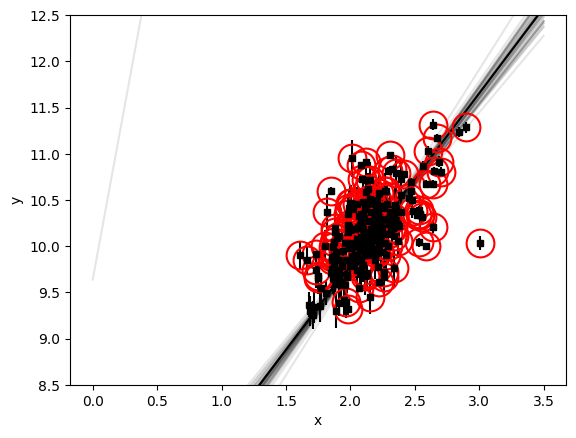

In [130]:
def check_outlier(theta, x, y, sy):
    m, b, Pb, Yb, Vb = theta
    lp = lnprior(theta)
    # probability of the data points in the line model (with the prior)
    lnpf = lnGau(m * x + b, y, sy**2) + np.log(1 - Pb) + lp
    # probability of the data points in the outlier model (with the prior)
    lnpb = lnGau(Yb, y, Vb + sy**2) + np.log(Pb) + lp
    return (lnpb > lnpf)

# plot the data
plt.figure(7)
plt.errorbar(
    x,
    y,
    sy,
    ls='None',
    mfc='k',
    mec='k',
    ms=5,
    marker='s',
    ecolor='k'
)
# plot the best fit line
plt.plot(X, fits[1][0] * X + fits[1][1], color='k')
print(fits[1][0],fits[1][1] )
# plot a sample of best fit lines
for i in idx:
    f = samples[i]
    plt.plot(X, f[0] * X + f[1], color='k', alpha=0.1)
# get the outliers
q_sample = np.array([check_outlier(sample, x, y, sy) for sample in samples])
q_mask = np.median(q_sample, axis=0).astype(bool)
print(len(x),len(x[q_mask]))
print(q_mask)
plt.plot(x[q_mask], y[q_mask], 'o', mfc='none', mec='r', ms=20, mew=1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(8.5,12.5)
